In [1]:
import pandas as pd
import pandas_profiling
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from mlxtend.plotting import plot_decision_regions
import pickle
from sklearn.externals import joblib # saving modelsa
%matplotlib inline
# make prettier plots
%config InlineBackend.figure_format = 'svg' 

# Class balancing
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline, make_pipeline

#Modeling
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Yellowbrick visuals-- used for model selection + metrics
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import DiscriminationThreshold
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.model_selection import FeatureImportances

/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.


In [2]:
# To load pickle back in
with open('df_cleaned.pickle','rb') as read_file:
    df = pickle.load(read_file)

In [3]:
df.columns

Index(['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Response', 'Age', 'total_accepted_offers',
       'Education_Graduation', 'Education_HigherEd',
       'Marital_Status_OnceMarried', 'Marital_Status_Single',
       'Marital_Status_Together', 'CustomerLength', 'TotalRevenueFoodItems'],
      dtype='object')

## Some further EDA by response group-- there are some strong difs potentially contributing

In [4]:
gb_response = df.groupby('Response')

In [5]:
gb_response['Income'].mean()

Response
0    50511.913390
1    60209.675676
Name: Income, dtype: float64

In [6]:
gb_response['TotalRevenueFoodItems'].mean()

Response
0    499.454835
1    924.408408
Name: TotalRevenueFoodItems, dtype: float64

In [7]:
gb_response['CustomerLength'].mean()

Response
0    522.769394
1    634.081081
Name: CustomerLength, dtype: float64

In [15]:
import pylift

In [16]:
from pylift import TransformedOutcome

In [17]:
# log the outcome (total revnue)

In [18]:
df['total_rev_log'] = np.log(df.TotalRevenueFoodItems)


In [31]:
up = TransformedOutcome(df, col_treatment='Response', col_outcome='TotalRevenueFoodItems',\
                        random_state=4, stratify=df['Response'])

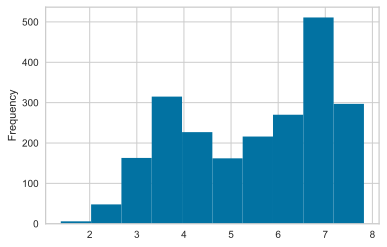

In [24]:
df.total_rev_log.plot(kind='hist')

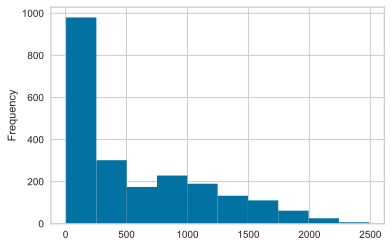

In [32]:
df.TotalRevenueFoodItems.plot(kind='hist')

## NIV = net information gain
- Kind of like feature selection
- WHY ARE THE EMPTY...

In [ ]:
# THIS SHOWS EMPTY FOR SOME REASON...
#up.NIV(feats_to_use= ['Recency', 'total_accepted_offers', 'TotalRevenueFoodItems'])

In [ ]:
# THIS SHOWS UP BUT WITH EMPTY BINS/DATA FOR SOME REASON
#up.NWOE()

In [35]:
# Same here... empty for each key
#up.NIV_dict

In [34]:
#up.test_results_.Q_qini

In [36]:
# Random search (like grid search)
up.randomized_search(n_iter=20, n_jobs=10, random_state=1)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    9.1s
[Parallel(n_jobs=10)]: Done  60 out of  60 | elapsed:   17.2s finished


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=1,
                                          objective='reg:linear',
                                          random_...
                                                      16, 17, 18, 19, 20],
                                        'min_child_weight': [1, 2, 3, 4, 5, 6,
                                   

In [37]:
# Fit model with raandom search best params
up.fit(**up.rand_search_.best_params_)

/anaconda3/envs/metis/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/envs/metis/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:47:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/anaconda3/envs/metis/lib/python3.7/site-packages/pylift/eval.py:343: RuntimeWarning: invalid value encountered in double_scalars
  - (sure_things[0])/(persuadables[0] + sure_things[0] + lost_causes[0])
/anaconda3/envs/metis/lib/python3.7/site-packages/pylift/eval.py:342: RuntimeWarning: divide by zero encountered in double_scalars
  kink_y = (persuadables[1] + sure_things[1])/(persuadables[1] + sure_things[1] + lost_causes[1]) \


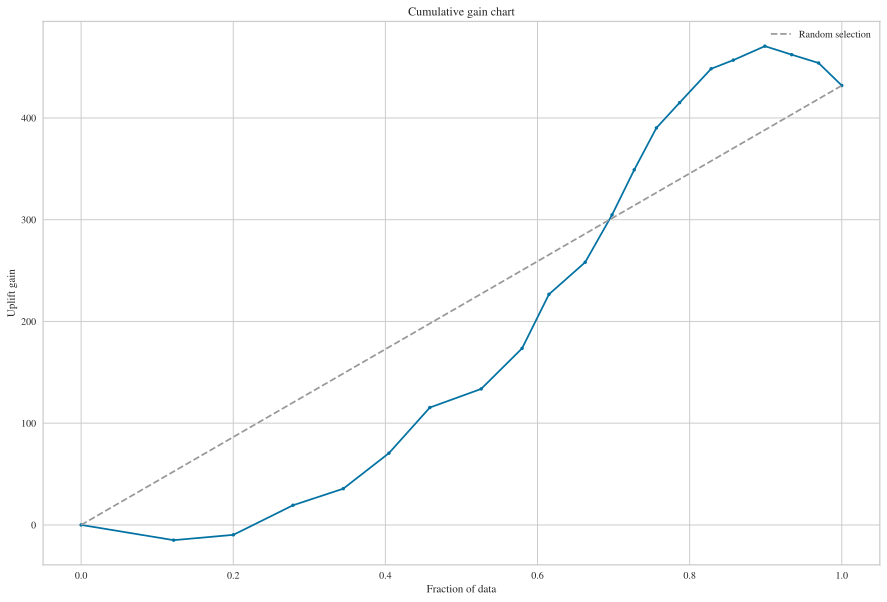

In [38]:
up.plot()

No handles with labels found to put in legend.


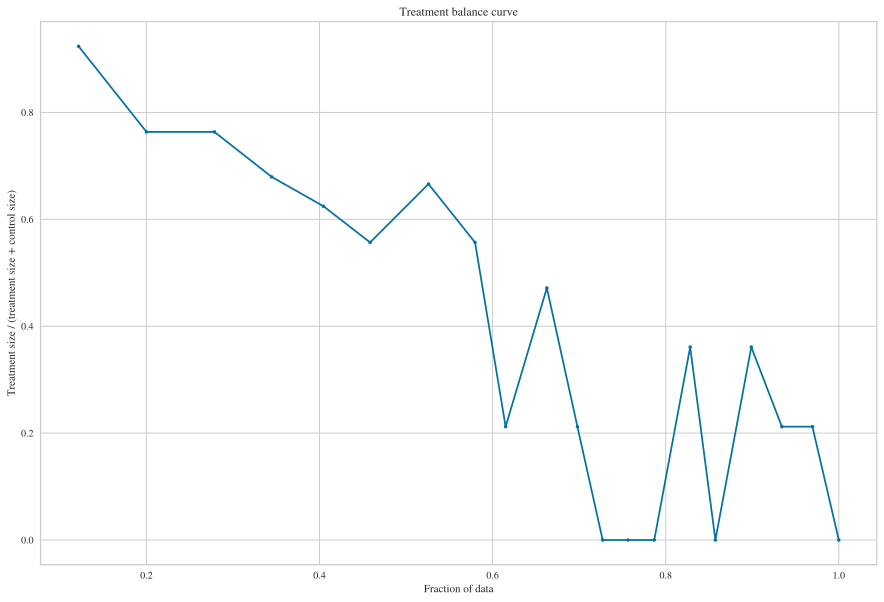

In [39]:
up.plot(plot_type='balance')

In [40]:
up.shuffle_fit(params=up.rand_search_.best_params_, nthread=30, iterations=5);


[11:47:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Seed 0 finished.
[11:47:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Seed 1 finished.
[11:47:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Seed 2 finished.
[11:47:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Seed 3 finished.
[11:47:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Seed 4 finished.


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


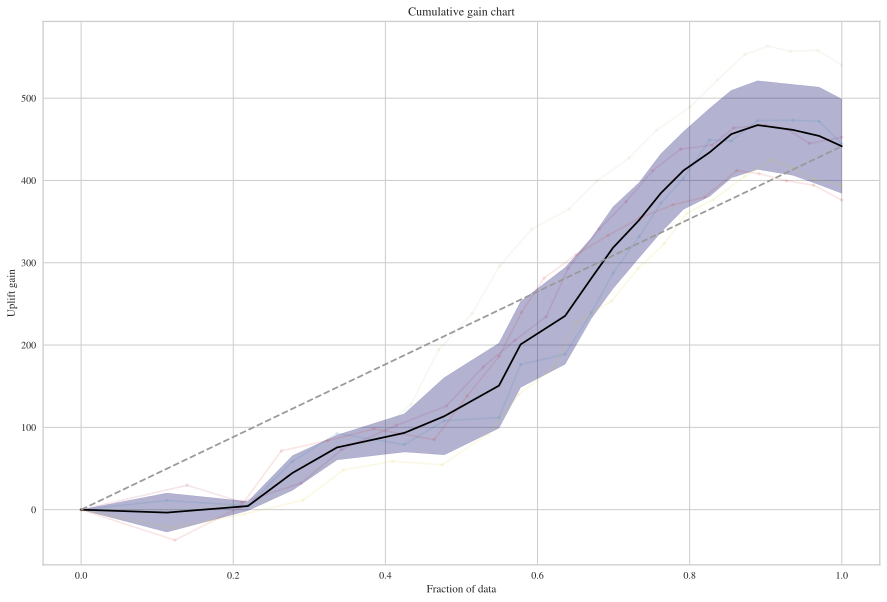

In [41]:
up.plot(show_shuffle_fits=True)
# on y axis it's incremental revenue gain as we move on x axis (fraction treated)

In [42]:
up.noise_fit()

In [ ]:
up.plot(show_noise_fits=True)

In [ ]:
up.plot(plot_type='aqini',
        show_shuffle_fits=True,
        show_random_selection=True,
        shuffle_band_kwargs={'color':[0.7,0.7,0.3], 'alpha':0.3},
        shuffle_lines_kwargs={'color':[0.3,0.3,0.3], 'alpha':0.2},
        shuffle_avg_line_kwargs={'color':[1,0,0]}
       )

In [ ]:
up.plot(show_theoretical_max=True, show_practical_max=True, show_no_dogs=True)


In [ ]:
up.plot(plot_type='cuplift', show_theoretical_max=True, show_practical_max=True, show_no_dogs=True)


In [ ]:
from pylift.eval import UpliftEval

In [ ]:
upev = UpliftEval(treatment,outcome,predictions)

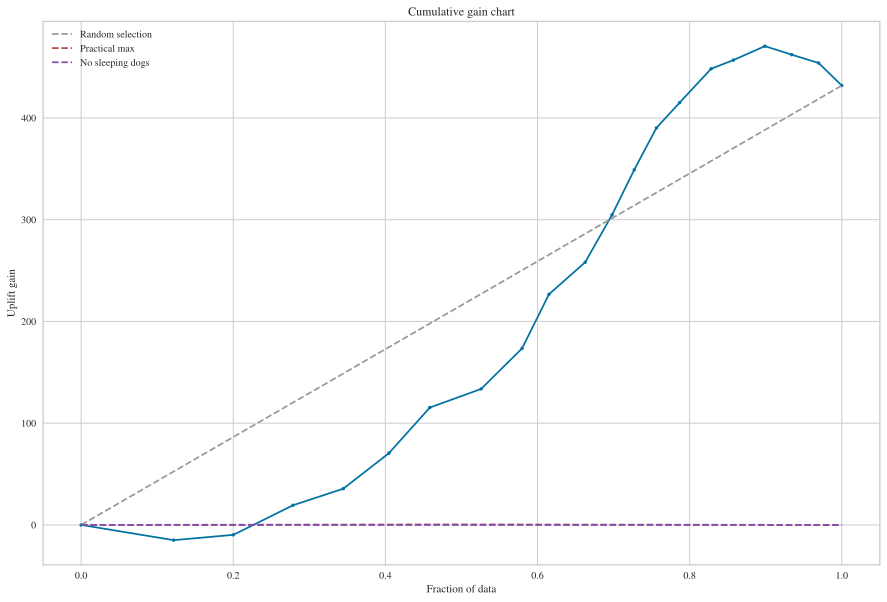

In [44]:
up.plot(plot_type='cgains', show_practical_max=True, show_no_dogs=True)